In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import gmaps
import os
import calendar
import calmap
import seaborn as sns
from PIL import Image

In [2]:
# Open listings and calendar dataframes

df_list = pd.read_csv('Midland_listings.csv')
df_cal = pd.read_csv('Calendar.csv')

In [14]:
df_list[df_list['listing.name']=='Right At Home-Midland Manor']

,listing.id,listing.user.id,listing.is_superhost,listing.city,listing.name,listing.property_type_id,listing.room_and_property_type,listing.space_type,listing.avg_rating,listing.reviews_count,...,listing.is_new_listing,listing.lat,listing.lng,listing.max_nights,listing.min_nights,pricing_quote.can_instant_book,pricing_quote.monthly_price_factor,pricing_quote.rate.amount,pricing_quote.weekly_price_factor,occupancy_rate
155,38594259,153682556,True,Midland,Right At Home-Midland Manor,2,Entire house,Entire house,4.97,29,...,False,32.03643,-102.16642,1125,1,False,0.9,149.0,0.9,0.203704


In [28]:
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23870 entries, 0 to 23869
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   listing.id  23870 non-null  int64 
 1   date        23870 non-null  object
 2   available   23870 non-null  bool  
 3   min_nights  23870 non-null  int64 
 4   max_nights  23870 non-null  int64 
dtypes: bool(1), int64(3), object(1)
memory usage: 769.4+ KB


In [3]:
# Create datetime data

df_cal['date'] = pd.to_datetime(df_cal['date'])

In [56]:
print(df_cal['date'][0].month)
print(df_cal['date'][0].year)
print(df_cal['date'][0].day)
print(calendar.day_name[df_cal['date'][0].weekday()])

4
2020
26
Sunday


In [84]:
# call months from entire column

#df_cal['date'].dt.month

In [83]:
# Sort table by calling one month

#df_cal[df_cal['date'].dt.month == 4]

In [4]:
# Eliminate data before scrape date

availability = df_cal[df_cal['date'] > '2020-05-18']
availability

,listing.id,date,available,min_nights,max_nights
23,42664313,2020-05-19,False,1,1125
24,42664313,2020-05-20,False,1,1125
25,42664313,2020-05-21,False,1,1125
26,42664313,2020-05-22,False,1,1125
27,42664313,2020-05-23,False,1,1125
...,...,...,...,...,...
23865,42670396,2020-06-30,True,6,14
23866,42670396,2020-07-01,True,2,14
23867,42670396,2020-07-02,True,2,14
23868,42670396,2020-07-03,True,2,14


In [158]:
# Merge availability and listings data frames by listing id

availability_two = pd.merge(availability, df_list, on='listing.id', how='left')
#df_list.iloc[:,[23]]

In [5]:
# Percentage availability for each listing based on Boolean values (Available = True/1, Booked = False/0)

listing_occupancy_rate = 1 - availability.groupby('listing.id').available.mean()

#listing_occupancy_rate
#df_list['occupancy_rate'] =
df_list = pd.merge(df_list, listing_occupancy_rate, on='listing.id', how='left')

In [6]:
# Rename merged column from listing_occupancy_rate to occupancy_rate.

df_list.rename(columns={'available':'occupancy_rate'},inplace=True)

In [8]:
#df_list

# PLOT DATA ON GOOGLE MAPS

## GMAPS
### Weighted Heatmap: Occupancy Rate

In [7]:
# Configure api_key to environment variable

gmaps.configure(api_key=os.environ['GMAPS_KEY'])

In [8]:
m = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(
    df_list[['listing.lat', 'listing.lng']], weights=df_list['occupancy_rate']
)
m.add_layer(heatmap_layer)
m

Figure(layout=FigureLayout(height='420px'))

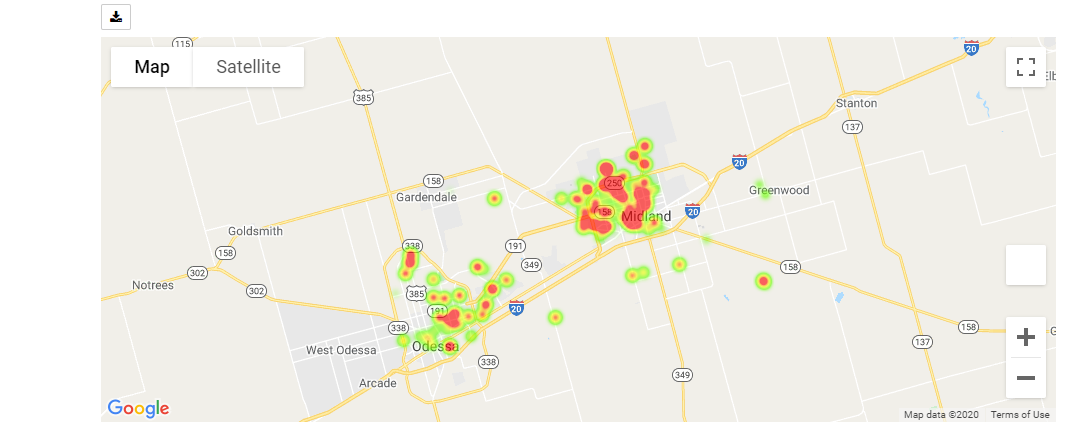

In [4]:
img = Image.open('Occupancy_Heatmap.png')
img

#### Change intensity and point_radius without having to call API every time.

In [9]:
heatmap_layer.max_intensity=1
heatmap_layer.point_radius=10.0

### Weighted Heatmap: Price

In [10]:
p = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(
    df_list[['listing.lat', 'listing.lng']], weights=df_list['pricing_quote.rate.amount']
)
p.add_layer(heatmap_layer)
p

Figure(layout=FigureLayout(height='420px'))

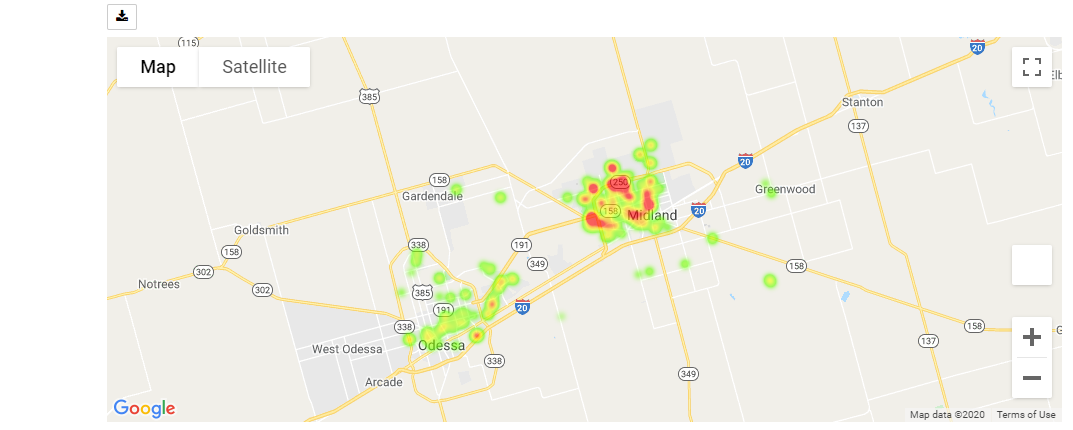

In [5]:
img2 = Image.open('Price_Heatmap.png')
img2

In [ ]:
heatmap_layer.max_intensity=1
heatmap_layer.point_radius=10.0

### Additional Plot Analysis

Text(0.5, 1.0, 'Number of Listings per Host')

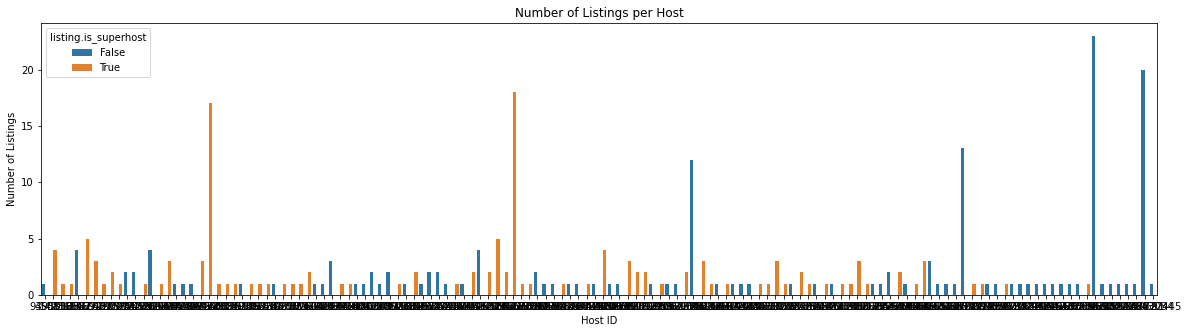

In [127]:
# Plot number of listings per host
plt.figure(figsize=(20,5))
sns.countplot(x='listing.user.id',data=df_list,hue='listing.is_superhost')
plt.xlabel('Host ID')
plt.ylabel('Number of Listings')
plt.title('Number of Listings per Host')

- There are a handful of 'hosts' or companies that have far more listings than avg.

Text(0, 0.5, 'Occupancy')

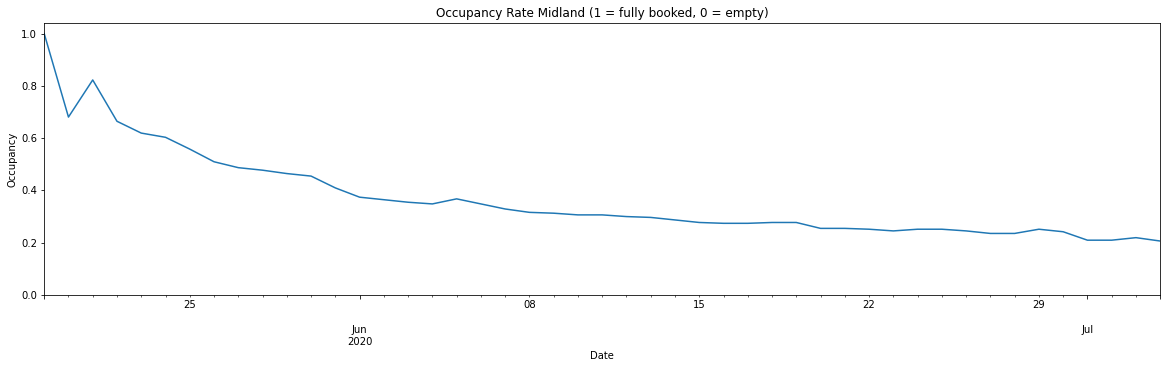

In [165]:
# Plot occupancy rates for gathered data (scraped data starting on 5/20, hence 100% up to then)

daily_occupancy_rate = 1 - availability.groupby('date')['available'].mean()
daily_occupancy_rate.plot(kind='line', figsize=(20,5))
plt.ylim(0)
plt.title('Occupancy Rate Midland (1 = fully booked, 0 = empty)')
plt.xlabel('Date')
plt.ylabel('Occupancy')

- Listings are not booked very far in advance. 
- Perhaps too many listings, or not enough people traveling to Midland.

In [92]:
# Least available listing (idxmin) and most available (idxmax)

print(availability['listing.id'].value_counts().idxmin()) # Claydesta apt.
print(availability['listing.id'].value_counts().idxmax()) # Odessa near business 20

37771086
31537016


Text(0, 0.5, 'Listings Count')

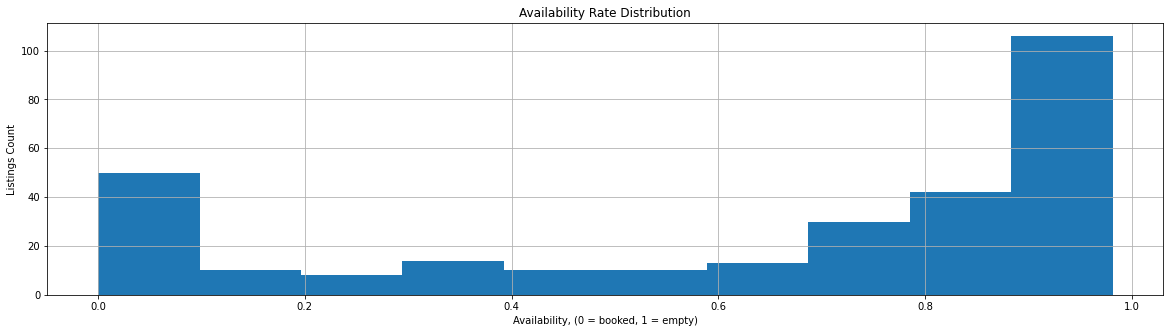

In [164]:
# count of listings by availability (0 = fully booked, 1 = empty)

availability.groupby('listing.id')['available'].mean().hist(figsize=(20,5))
plt.title('Availability Rate Distribution')
plt.xlabel('Availability, (0 = booked, 1 = empty)')
plt.ylabel('Listings Count')

In [ ]:
# Calmap heatmap visualization of daily_occupancy_rate - not working - 

#calmap.calendarplot(daily_occupancy_rate, fig_kws=dict(figsize=(15, 5), dpi=200))
#calmap.yearplot(daily_occupancy_rate, year=2020)

Text(0.5, 1.0, 'Availability vs. Rate')

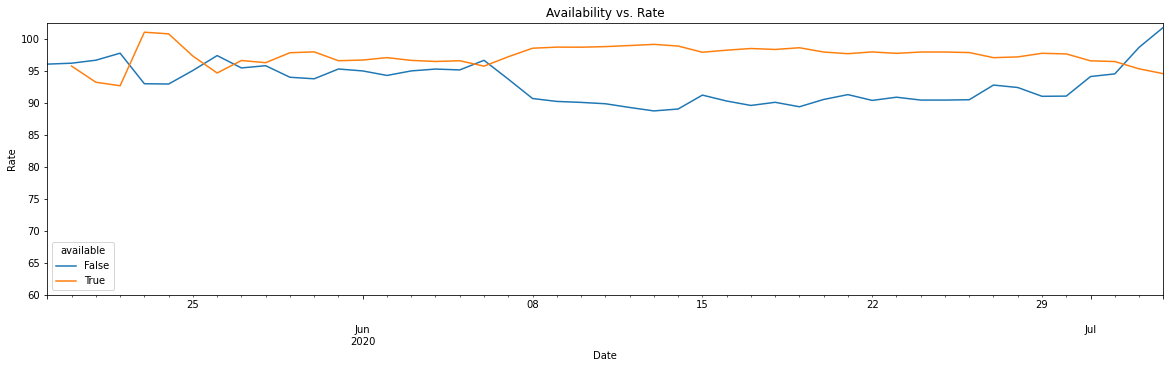

In [162]:
availability_two.groupby(['available', 'date'])['pricing_quote.rate.amount'].mean().unstack().transpose() \
    .plot(kind='line', figsize=(20,5))
plt.ylim(60)
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Availability vs. Rate')

- There is a clear difference in avg. rate 16 days from current date.
- Showing that on average, lower priced listings potentially book further in advance in Midland.

In [64]:
# Pivot table Availabilty by listing 

df_avail = df_cal.pivot_table(values='available', index='listing.id', columns='date')
df_avail

date,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,...,2020-06-25,2020-06-26,2020-06-27,2020-06-28,2020-06-29,2020-06-30,2020-07-01,2020-07-02,2020-07-03,2020-07-04
listing.id,,,,,,,,,,,,,,,,,,,,,
2614374,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
3811061,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9465528,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11582930,False,False,False,False,False,False,False,False,False,False,...,False,True,True,True,True,True,True,True,True,True
13128133,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43465853,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
43468405,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
43474505,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


In [43]:
# availability for given listing and date

df_avail.loc[2614374, '2020-04-26']

False

In [63]:
# all listings for given date

df_avail.loc[:,'2020-04-26']

listing.id
2614374     False
3811061     False
9465528     False
11582930    False
13128133    False
            ...  
43465853    False
43468405    False
43474505    False
43479937    False
43485490    False
Name: 2020-04-26 00:00:00, Length: 293, dtype: bool

In [9]:
df_list.columns

Index(['listing.id', 'listing.user.id', 'listing.is_superhost', 'listing.city',
       'listing.name', 'listing.property_type_id',
       'listing.room_and_property_type', 'listing.space_type',
       'listing.avg_rating', 'listing.reviews_count', 'listing.picture_count',
       'listing.bathrooms', 'listing.bedrooms', 'listing.beds',
       'listing.person_capacity', 'listing.cancel_policy',
       'listing.is_new_listing', 'listing.lat', 'listing.lng',
       'listing.max_nights', 'listing.min_nights',
       'pricing_quote.can_instant_book', 'pricing_quote.monthly_price_factor',
       'pricing_quote.rate.amount', 'pricing_quote.weekly_price_factor',
       'occupancy_rate'],
      dtype='object')

In [10]:
df_plots = df_list[['listing.is_superhost','listing.avg_rating','listing.reviews_count','listing.bedrooms',
                   'listing.person_capacity','listing.min_nights','pricing_quote.rate.amount',
                    'pricing_quote.weekly_price_factor','pricing_quote.monthly_price_factor','occupancy_rate'
                   ]].copy()
df_plots

,listing.is_superhost,listing.avg_rating,listing.reviews_count,listing.bedrooms,listing.person_capacity,listing.min_nights,pricing_quote.rate.amount,pricing_quote.weekly_price_factor,pricing_quote.monthly_price_factor,occupancy_rate
0,False,NaN,0,4,6,1,50.0,0.90,0.80,0.092593
1,False,NaN,2,3,6,4,165.0,1.00,1.00,0.981481
2,False,NaN,2,2,3,3,150.0,1.00,1.00,0.018519
3,False,4.27,15,2,6,1,60.0,0.85,0.70,0.888889
4,False,NaN,2,1,3,1,60.0,0.90,0.80,0.481481
...,...,...,...,...,...,...,...,...,...,...
290,False,4.48,25,1,1,2,29.0,0.95,1.00,1.000000
291,True,4.79,94,1,2,1,31.0,0.95,0.85,0.074074
292,False,NaN,0,2,5,30,68.0,1.00,1.00,0.944444
293,True,4.94,80,1,2,1,32.0,0.99,0.99,1.000000


In [12]:
df_pairplot_one = df_list[['listing.is_superhost','listing.avg_rating','listing.reviews_count',
                           'pricing_quote.rate.amount','occupancy_rate']].copy()

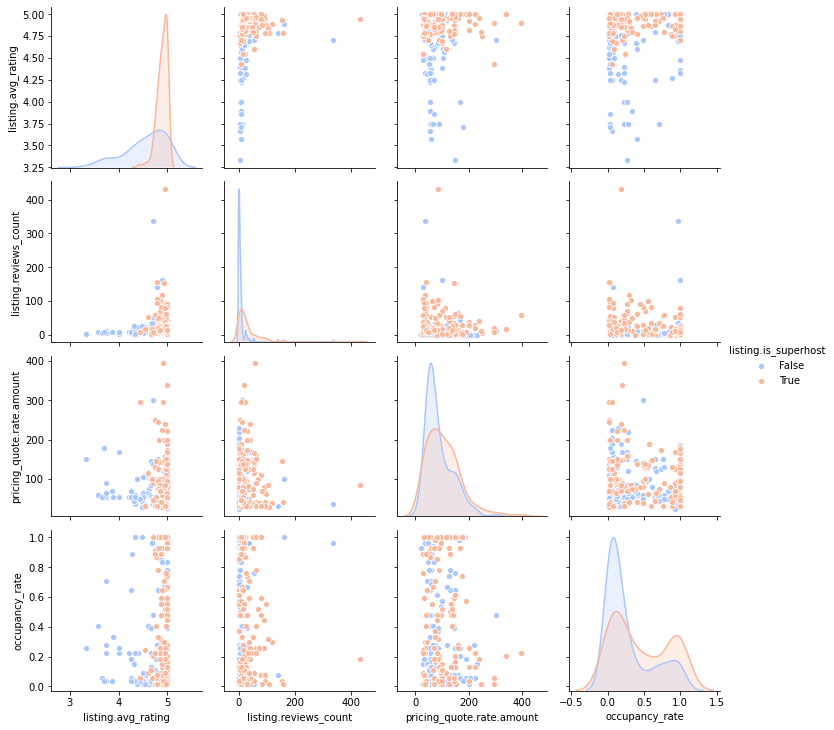

In [14]:
sns.pairplot(df_pairplot_one,hue='listing.is_superhost',palette='coolwarm')

- Higer ratings tend to have more reviews (strongest correlation)
- lower priced listings have more reviews (some corr.)
- Lower ratings tend to be concentrated in lower priced listings, as well as lower occupancy rate (weak corr.)

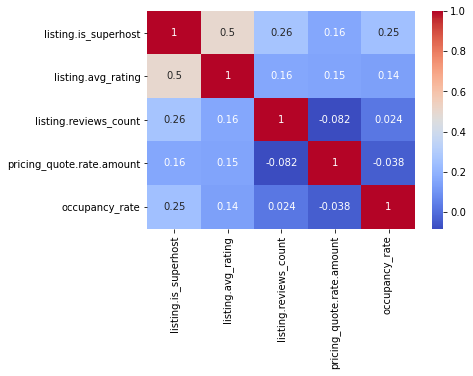

In [23]:
sns.heatmap(df_pairplot_one.corr(),annot=True,cmap='coolwarm')

In [17]:
df_pairplot_two = df_list[['listing.is_superhost','listing.bedrooms','listing.person_capacity','listing.min_nights',
                           'pricing_quote.rate.amount','pricing_quote.weekly_price_factor',
                           'pricing_quote.monthly_price_factor','occupancy_rate']].copy()

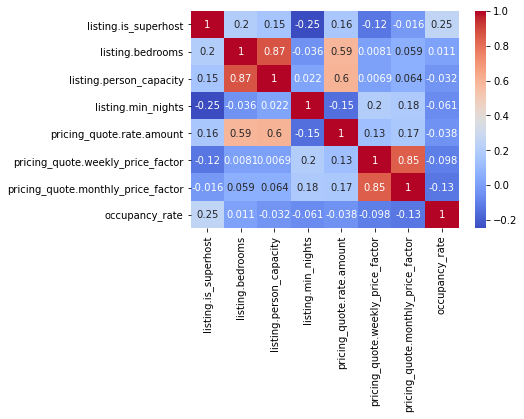

In [24]:
sns.heatmap(df_pairplot_two.corr(),annot=True,cmap='coolwarm')

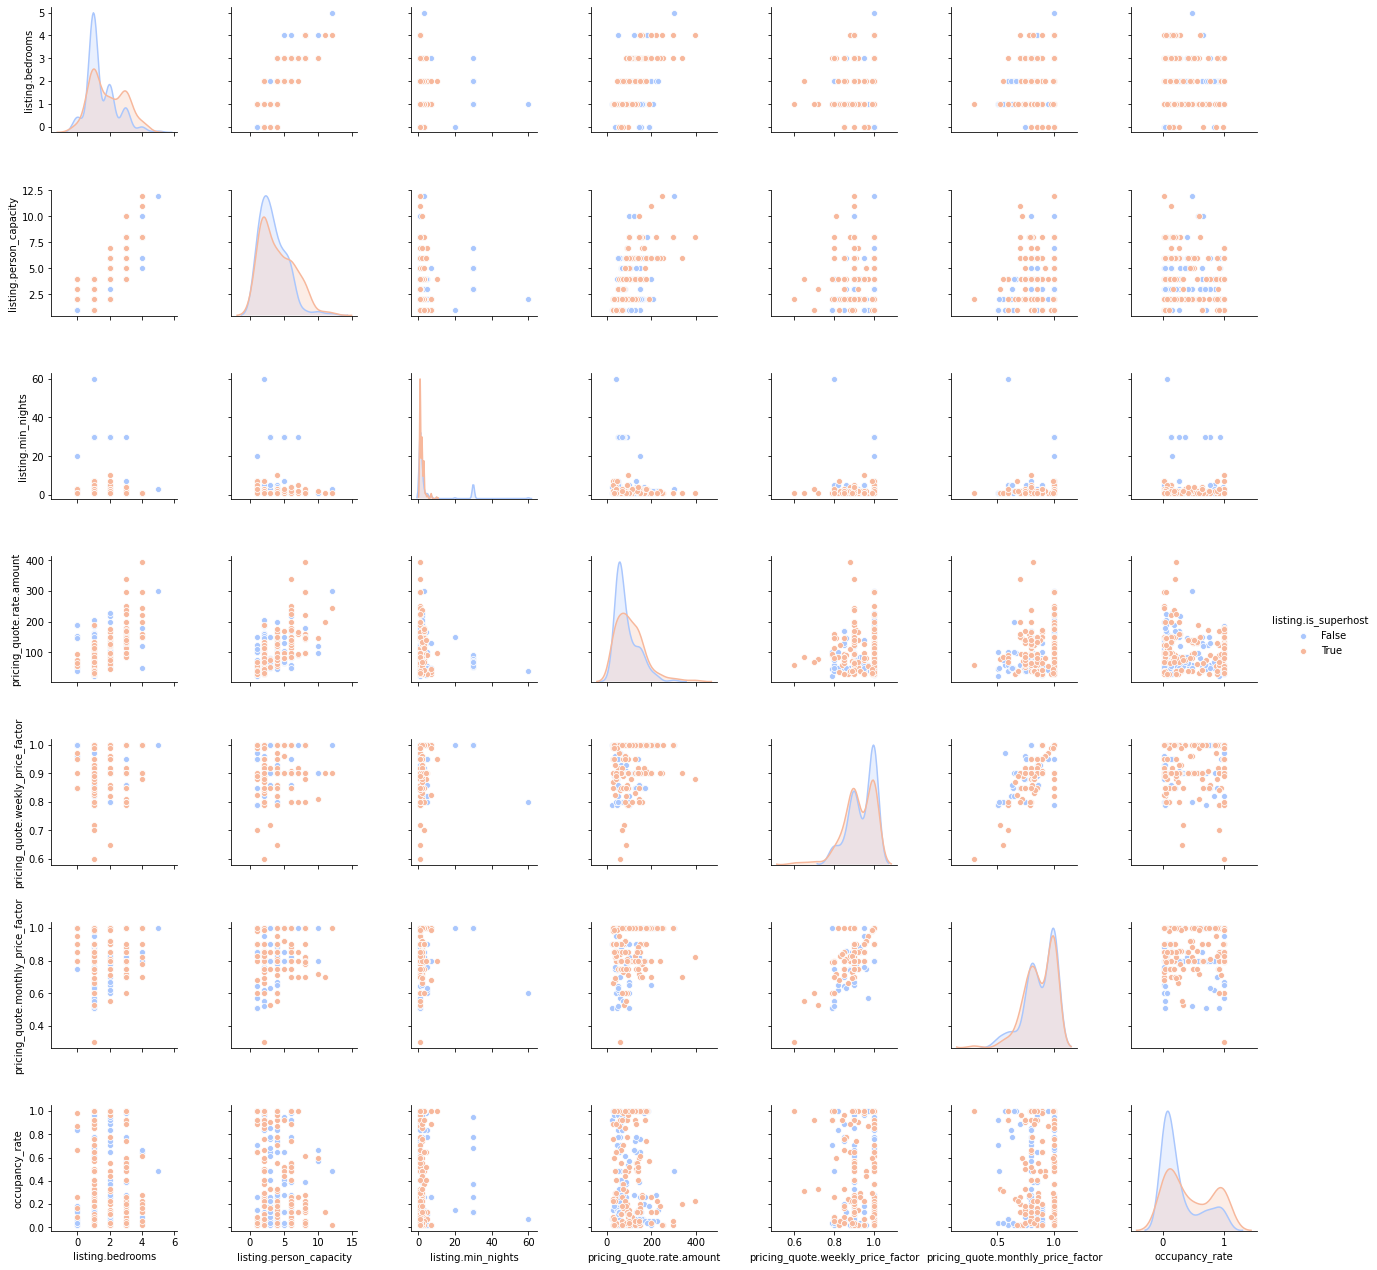

In [18]:
sns.pairplot(df_pairplot_two,hue='listing.is_superhost',palette='coolwarm')

- Occupancy shows weak correlation to listing price.
- The only correlation is b/w price and beds/capacity

# Linear Regression Model

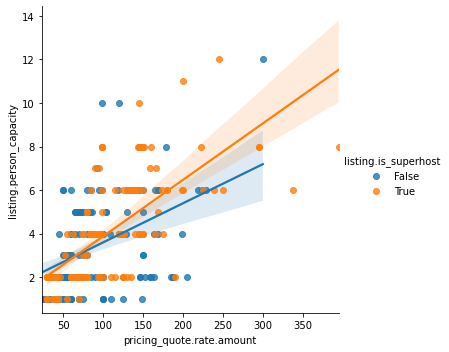

In [19]:
# Linear regression plot analysis

sns.lmplot(x='pricing_quote.rate.amount',y='listing.person_capacity',data=df_list,hue='listing.is_superhost')

In [110]:
# Only calling superhost listings for model
X = df_list[df_list['listing.is_superhost']][['listing.bedrooms','listing.person_capacity']]
y = df_list[df_list['listing.is_superhost']]['pricing_quote.rate.amount']
# X.reset_index(drop=True)
# y.reset_index(drop=True)

### Train Test Split

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train_test_split

<function sklearn.model_selection._split.train_test_split(*arrays, **options)>

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

### Creating and Training the Model

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
lm = LinearRegression()  # instantiate LinearRegression to lm

In [112]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Model Eval

In [113]:
print(lm.intercept_)  # Is this intercept the same for both groups of data?
print(lm.coef_)

22.568723720043934
[25.86045842  9.85233797]


In [114]:
coeff_df = pd.DataFrame(data=lm.coef_,index=X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
listing.bedrooms,25.860458
listing.person_capacity,9.852338


- Holding all other features fixed, a 1 unit increase in bedrooms is associated with an increase of \\$25.86
- Holding all other features fixed, a 1 unit increase in capacity is associated with an increase of \\$9.85

In [126]:
print('Estimated price of four person listing: $%1.2f' %(22.568723720043934 + 9.85233797*4))
print('Estimated price of six person listing: $%1.2f\n' %(22.568723720043934 + 9.85233797*6))
print('Estimated price of two bedroom listing: $%1.2f' %(22.568723720043934 + 25.86045842*2))
print('Estimated price of three bedroom listing: $%1.2f' %(22.568723720043934 + 25.86045842*3))

Estimated price of four person listing: $61.98
Estimated price of six person listing: $81.68

Estimated price of two bedroom listing: $74.29
Estimated price of three bedroom listing: $100.15


### Predictions for Model

In [115]:
predictions = lm.predict(X_test)

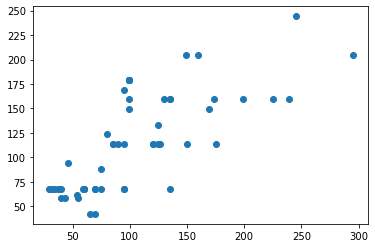

In [125]:
plt.scatter(y_test,predictions)

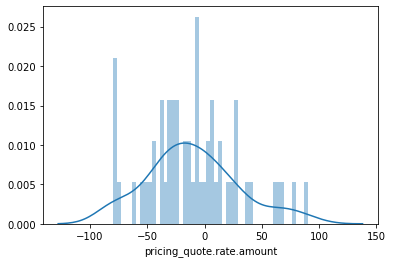

In [117]:
sns.distplot((y_test-predictions),bins=50)

### Regression Evaluation Metrics

In [48]:
from sklearn import metrics

In [119]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 32.766380631714185
MSE: 1678.5723588355115
RMSE: 40.97038392345758
